In [1]:
import wandb
wandb.init(project='ChannelCharting')

W&B Run: https://app.wandb.ai/evs/ChannelCharting/runs/3cfqyfqn

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append("../src")
import utils.data_preparation as dp
import utils.metrics as metrics
from models import siamese

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import MSELoss

from sklearn.model_selection import train_test_split

In [4]:
# read data
data = np.load("../Data/RayTracingData/Remcom_4x4_IR_100taps.npy")
rx_positions = np.load("../Data/RayTracingData/Remcom_4x4_rxpos.npy")
true_pos = rx_positions[:,:2]

## Setting up the Custom Dataset

In [28]:
# undersampling
idces = np.random.randint(0, data.shape[0], int(0.01*data.shape[0]))
data_undersampled = data[idces]
true_pos_undersampled = true_pos[idces]

In [32]:
# train test split
train_X, test_X= train_test_split(data_undersampled)
train_y, test_y= train_test_split(true_pos_undersampled)

In [33]:
train_dataset = dp.SiameseDataset(train_X, train_y)
scaler_X = train_dataset.scaler_real, train_dataset.scaler_imag
scaler_y = train_dataset.scaler_y
test_dataset = dp.SiameseDataset(test_X, test_y, scaler_X, scaler_y)

In [34]:
train_dataset.nb_channels()

32

In [35]:
class SimpleNN(nn.Module):
    def __init__(self, dropout):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=train_dataset.nb_channels(),
                          out_channels=128,
                          kernel_size=16)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(in_channels=128, 
                          out_channels=64,
                          kernel_size=8)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64,
                          out_channels=16,
                          kernel_size=4)
        self.bn3 = nn.BatchNorm1d(16)
        
        f = siamese.conv1d_output_size
        self.features = f(f(f(train_dataset.nb_samples(),kernel_size=16),
                                                       kernel_size=8), 
                                                         kernel_size=4)

        
        
        self.lin1 = nn.Linear(in_features= 16 * self.features, out_features=128)
        self.lin2 = nn.Linear(in_features=128, out_features=32)
        self.lin3 = nn.Linear(in_features=32, out_features=8)
        self.lin4 = nn.Linear(in_features=8, out_features=2)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.bn1(F.selu(self.conv1(x)))
        x = self.bn2(F.selu(self.conv2(x)))
        x = self.bn3(F.selu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(F.selu(self.lin1(x)))
        x = self.dropout(F.selu(self.lin2(x)))
        x = self.dropout(F.selu(self.lin3(x)))
        
        out = self.lin4(x)
        
        return out
        
    

In [36]:
dropout = 0.3
model = SimpleNN(dropout)


In [11]:
def loss_function(x1, x2, y1, y2):
    return torch.mean((torch.dist(x1,x2) - torch.dist(y1, y2))**2/(torch.dist(x1,x2) + 1e-5))

## Training

In [12]:
a = len(test_dataset)/len(train_dataset)
batch_size = 32

In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
supervised_criterion = loss_function
optimizer = optim.Adam(model.parameters())


In [14]:
#wandb.log({"Batch_size": batch_size,
#           "Dropout": dropout
#          })
for e in range(40):
    # train
    loss = 0
    
    for (x1, y1), (x2, y2) in train_loader:
        
        
        optimizer.zero_grad()
        yhat1, yhat2 = model(x1), model(x2)
        
        #supervised
        batch_loss = supervised_criterion(yhat1, yhat2, y1 ,y2)
        
        batch_loss.backward()
        optimizer.step()
    
        loss+=batch_loss
    
    #validation
    model.eval()
    val_loss = 0
    for (x1, y1), (x2, y2) in test_loader:
        y1, y2 = model(x1), model(x2)
        val_loss += supervised_criterion(yhat1, yhat2, y1 ,y2)
    
    wandb.log({
        "Training Loss": a*loss,
        "Validation Loss": val_loss,
    })
    print(f"Epoch {e+1}, Training Loss: {a*loss}, Validation Loss: {val_loss}")

wandb: Wandb version 0.8.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1, Training Loss: 59.840179443359375, Validation Loss: 112.69076538085938
Epoch 2, Training Loss: 27.797075271606445, Validation Loss: 220.27191162109375
Epoch 3, Training Loss: 19.93855094909668, Validation Loss: 50.6134147644043
Epoch 4, Training Loss: 13.46564769744873, Validation Loss: 525.0740966796875
Epoch 5, Training Loss: 14.860119819641113, Validation Loss: 464.4764404296875
Epoch 6, Training Loss: 12.18165397644043, Validation Loss: 277.5961608886719
Epoch 7, Training Loss: 14.475183486938477, Validation Loss: 370.56658935546875
Epoch 8, Training Loss: 10.626973152160645, Validation Loss: 378.9350280761719
Epoch 9, Training Loss: 10.672843933105469, Validation Loss: 195.6412811279297
Epoch 10, Training Loss: 10.392059326171875, Validation Loss: 125.70916748046875
Epoch 11, Training Loss: 10.382134437561035, Validation Loss: 331.61627197265625
Epoch 12, Training Loss: 10.233940124511719, Validation Loss: 487.1954040527344
Epoch 13, Training Loss: 9.530137062072754, Vali

KeyboardInterrupt: 

## Evaluate results

In [37]:
yhats = model(test_dataset[:][0][0]).detach()
y = test_dataset[:][0][1].detach()
X = test_dataset[:][0][0]

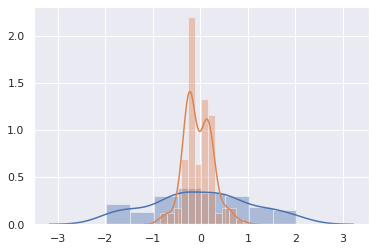

In [38]:
sns.distplot(y)
sns.distplot(yhats)
#sns.distplot(test_dataset[:][0][0])

In [39]:
y.median(), y.std(), yhats.median(), yhats.std()

(tensor(-0.0523), tensor(1.0495), tensor(-0.1008), tensor(0.2978))

In [40]:
test_dataset[:][0][0].min(), test_dataset[:][0][0].max(), test_dataset[:][0][0].median(), test_dataset[:][0][0].std()

(tensor(-14.8733), tensor(14.8150), tensor(-0.0008), tensor(0.1644))

In [41]:
y.shape, yhats.shape

(torch.Size([60, 2]), torch.Size([60, 2]))

In [42]:
yhats = yhats.detach()

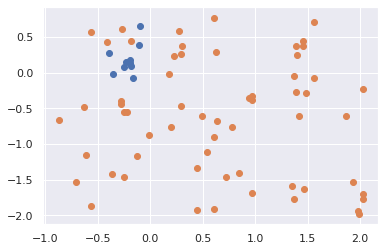

In [43]:
plt.scatter(yhats[:10,0], yhats[:10,1])
plt.scatter(y[:,0], y[:,1])

In [55]:
def trustworthiness(orig, proj, ks):
    """Calculate a trustworthiness values for dataset.
    orig
      matrix containing the data in the original space
    proj
      matrix containing the data in the projected space
    ks range indicating neighbourhood(s) for which
      trustworthiness is calculated.
    Return list of trustworthiness values
    """

    dd_orig = metrics.distance_matrix(orig)
    dd_proj = metrics.distance_matrix(proj)
    nn_orig = dd_orig.argsort()
    nn_proj = dd_proj.argsort()

    ranks_orig = metrics.rank_matrix(dd_orig)

    trust = []
    for k in ks:
        moved = []
        for i in range(orig.shape[0]):
            moved.append(moved_in(nn_orig, nn_proj, i, k))

        trust.append(trustcont_sum(moved, ranks_orig, k))

    return trust

def continuity(orig, proj, ks):
    """Calculate a continuity values for dataset
    orig
      matrix containing the data in the original space
    proj
      matrix containing the data in the projected space
    ks range indicating neighbourhood(s) for which continuity
      is calculated.
    Return a list of continuity values
    """

    dd_orig = metrics.distance_matrix(orig)
    dd_proj = metrics.distance_matrix(proj)
    nn_orig = dd_orig.argsort()
    nn_proj = dd_proj.argsort()

    ranks_proj = metrics.rank_matrix(dd_proj)

    cont = []
    for k in ks:
        moved = []
        for i in range(orig.shape[0]):
            moved.append(moved_out(nn_orig, nn_proj, i, k))

        cont.append(trustcont_sum(moved, ranks_proj, k))

    return cont

def moved_out(nn_orig, nn_proj, i, k):
    """Determine points that were neighbours in the original space,
    but are not neighbours in the projection space.
    nn_orig
      neighbourhood matrix for original data
    nn_proj
      neighbourhood matrix for projection data
    i
      index of the point considered
    k
      size of the neighbourhood considered
    Return a list of indices for 'moved out' values 
    """

    oo = list(nn_orig[i, 1:k+1])
    pp = list(nn_proj[i, 1:k+1])

    for j in pp:
        if (j in pp) and (j in oo):
            oo.remove(j)

    return oo

def moved_in(nn_orig, nn_proj, i, k):
    """Determine points that are neighbours in the projection space,
    but were not neighbours in the original space.
    nn_orig
      neighbourhood matrix for original data
    nn_proj
      neighbourhood matrix for projection data
    i
      index of the point considered
    k
      size of the neighbourhood considered
    Return a list of indices for points which are 'moved in' to point i
    """

    pp = list(nn_proj[i, 1:k+1])
    oo = list(nn_orig[i, 1:k+1])

    for j in oo:
        if (j in oo) and (j in pp):
            pp.remove(j)

    return pp


def scaling_term(k, n):
    """Term that scales measure between zero and one
    k  size of the neighbourhood
    n  number of datapoints
    """
    if k < (n / 2.0):
        return 2.0 / ((n*k)*(2*n - 3*k - 1))
    else:
        return 2.0 / (n * (n - k) * (n - k - 1))


def trustcont_sum(moved, ranks, k):
    """Calculate sum used in trustworthiness or continuity calculation.
    moved
       List of lists of indices for those datapoints that have either
       moved away in (Continuity) or moved in (Trustworthiness)
       projection
    ranks
       Rank matrix of data set. For trustworthiness, ranking is in the
       original space, for continuity, ranking is in the projected
       space.
    k
       size of the neighbournood
    """

    n = ranks.shape[0]
    s = 0

    # todo: weavefy this for speed
    for i in range(n):
        for j in moved[i]:
            s = s + (ranks[i, j] - k)

    a = scaling_term(k, n)

    return 1 - a * s

In [56]:
continuity(X ,y.unsqueeze(2) , range(1,5))

[tensor(0.6193), tensor(0.5751), tensor(0.5647), tensor(0.5636)]

In [46]:
X.shape

torch.Size([60, 32, 100])